In [1]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.collections import LineCollection

from scipy.optimize import curve_fit
from scipy.stats import chi2, norm

import math as mt

import naima

from astropy import units as u
from astropy.units import Quantity, Unit
from astropy.time import Time
from astropy.table import vstack
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion

import numpy as np

import csv

In [2]:
from gammapy.data import DataStore
from gammapy.data import EventList

from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    FoVBackgroundMaker,
    AdaptiveRingBackgroundMaker,
    RingBackgroundMaker
)

from gammapy.irf import (
    Background3D,
    EnergyDispersion2D,
    EffectiveAreaTable2D                      
)

from gammapy.data import (
    Observation,
    HDUIndexTable,
)

from gammapy.maps import Map, MapAxis, WcsGeom,RegionGeom

from gammapy.datasets import (
    MapDataset,
    MapDatasetOnOff,
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    LogParabolaSpectralModel,
    ExpDecayTemporalModel,
    ExpCutoffPowerLawSpectralModel,
    GaussianTemporalModel,
    SineTemporalModel,
    PowerLawTemporalModel,
    ExpCutoffPowerLawSpectralModel
)

from gammapy.visualization import (
    plot_theta_squared_table,
    plot_spectrum_datasets_off_regions
)

from gammapy.makers.utils import make_theta_squared_table


from gammapy.estimators import (
    TSMapEstimator,
    ExcessMapEstimator,
    LightCurveEstimator,
    FluxPointsEstimator,
    FluxPoints,
    SensitivityEstimator
)

from gammapy.stats import (
    WStatCountsStatistic
)

from gammapy.modeling.models import Models, NaimaSpectralModel, SkyModel


# Spectral model and particle distribution

In [3]:
from scipy.integrate import quad

#Fermi paper gives the total Flux above 300 MeV, but gammapy uses the parametrization
# of the amplitude at a certain energy as the parameter of the spectral model

def obtain_amplitude_expocutoff(e_inf,e_sup,Gamma,Ecutoff,E0,Flux):
    """
    Obtain the amplitude at a given reference energy E0.
    """
    def power_law_expocutoff(energy,Gamma,Ecutoff,E0):
        y=(energy/E0)**(-Gamma)*np.exp(-energy/Ecutoff)
        return y


    Integral=quad(power_law_expocutoff,
                  e_inf.value,
                  e_sup.value,
                  args=(Gamma,
                       Ecutoff.to_value(e_inf.unit),
                       E0.to_value(e_inf.unit))
    )*e_inf.unit


    A=Flux/Integral[0]
    
    return A.to("TeV-1 cm-2 s-1")

### V407Cyg

In [4]:
e_inf=0.1*u.GeV
e_sup=np.inf*u.GeV
Gamma=1.23
Ecutoff=1.44*u.GeV
E0=130*u.GeV
Flux=4.3e-7*u.Unit("cm-2 s-1")

V407Cyg=ExpCutoffPowerLawSpectralModel(
    amplitude=obtain_amplitude_expocutoff(e_inf,e_sup,Gamma,Ecutoff,E0,Flux).to("GeV-1 s-1 cm-2"),
    index=Gamma,
    reference=E0,
    lambda_=1/Ecutoff
)

#Using Fermi Nova paper!!! not simulations from Martin et al. 2018
mej_Cyg=1e-6
vej_Cyg=3200
nej_Cyg=6e8*((mej_Cyg/1e-6)*(vej_Cyg/4500)**(-3))
d_Cyg=2.7*u.kpc
print("{:1.1e}".format(nej_Cyg))

1.7e+09


### V1324Sco

In [5]:
e_inf=0.1*u.GeV
e_sup=np.inf*u.GeV
Gamma=1.77
Ecutoff=4.1*u.GeV
E0=130*u.GeV
Flux=4.93e-7*u.Unit("cm-2 s-1")

V1324Sco=ExpCutoffPowerLawSpectralModel(
    amplitude=obtain_amplitude_expocutoff(e_inf,e_sup,Gamma,Ecutoff,E0,Flux).to("GeV-1 s-1 cm-2"),
    index=Gamma,
    reference=E0,
    lambda_=1/Ecutoff
)

mej_Sco=1e-5
vej_Sco=2200
nej_Sco=6e8*((mej_Sco/1e-6)*(vej_Sco/4500)**(-3))
d_Sco=6.5*u.kpc
print("{:1.1e}".format(nej_Sco))

5.1e+10


### V959Mon

In [6]:
e_inf=0.1*u.GeV
e_sup=np.inf*u.GeV
Gamma=1.69
Ecutoff=1.45*u.GeV
E0=130*u.GeV
Flux=4.13e-7*u.Unit("cm-2 s-1")

V959Mon=ExpCutoffPowerLawSpectralModel(
    amplitude=obtain_amplitude_expocutoff(e_inf,e_sup,Gamma,Ecutoff,E0,Flux).to("GeV-1 s-1 cm-2"),
    index=Gamma,
    reference=E0,
    lambda_=1/Ecutoff
)

mej_Mon=6e-5
vej_Mon=3000
nej_Mon=6e8*((mej_Mon/1e-6)*(vej_Mon/4500)**(-3))
d_Mon=1.4*u.kpc
print("{:1.1e}".format(nej_Mon))

1.2e+11


### V339Del

In [7]:
e_inf=0.1*u.GeV
e_sup=np.inf*u.GeV
Gamma=1.72
Ecutoff=1.94*u.GeV
E0=130*u.GeV
Flux=1.93e-7*u.Unit("cm-2 s-1")

V339Del=ExpCutoffPowerLawSpectralModel(
    amplitude=obtain_amplitude_expocutoff(e_inf,e_sup,Gamma,Ecutoff,E0,Flux).to("GeV-1 s-1 cm-2"),
    index=Gamma,
    reference=E0,
    lambda_=1/Ecutoff
)

mej_Del=8e-5
vej_Del=2000
nej_Del=6e8*((mej_Del/1e-6)*(vej_Del/4500)**(-3))
d_Del=4.5*u.kpc
print("{:1.1e}".format(nej_Del))

5.5e+11


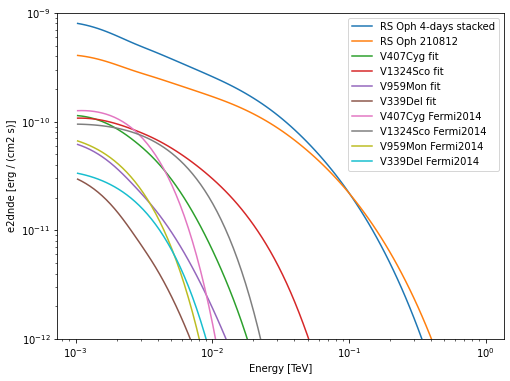

In [8]:
#Particle distribution from naima

particle_distribution = naima.models.ExponentialCutoffPowerLaw(8e31*u.Unit('1/eV'), 
                                                               130.0 * u.GeV, 
                                                               2.44, 
                                                               0.28*u.TeV)
radiative_model = naima.models.PionDecay(particle_distribution, nh=6.0e8 * u.cm ** -3)
spec_model = NaimaSpectralModel(radiative_model, distance=2.5 * u.kpc)

day4particle_distribution = naima.models.ExponentialCutoffPowerLaw(5e31*u.Unit('1/eV'), 
                                                                   130.0 * u.GeV, 
                                                                   2.35, 
                                                                   0.37*u.TeV)
radiative_model2 = naima.models.PionDecay(day4particle_distribution, nh=6.0e8 * u.cm ** -3)
spec_model2 = NaimaSpectralModel(radiative_model2, distance=2.5 * u.kpc)


Cyg_particle_distribution = naima.models.ExponentialCutoffPowerLaw(1.6e33*u.Unit('1/eV'), 
                                                                   130.0 * u.GeV, 
                                                                   0.8, 
                                                                   7.7*u.GeV)
Cyg_radiative_model = naima.models.PionDecay(Cyg_particle_distribution, nh=1.7e9 * u.cm ** -3)
Cyg_spec_model = NaimaSpectralModel(Cyg_radiative_model, distance=2.7 * u.kpc)



Sco_particle_distribution = naima.models.ExponentialCutoffPowerLaw(1.1e31*u.Unit('1/eV'), 
                                                                   130.0 * u.GeV, 
                                                                   1.6, 
                                                                   30*u.GeV)
Sco_radiative_model = naima.models.PionDecay(Sco_particle_distribution, nh=5.1e10 * u.cm ** -3)
Sco_spec_model = NaimaSpectralModel(Sco_radiative_model, distance=6.5 * u.kpc)



Mon_particle_distribution = naima.models.ExponentialCutoffPowerLaw(1.6e29*u.Unit('1/eV'), 
                                                                   130.0 * u.GeV, 
                                                                   1.8, 
                                                                   10*u.GeV)
Mon_radiative_model = naima.models.PionDecay(Mon_particle_distribution, nh=1.2e11 * u.cm ** -3)
Mon_spec_model = NaimaSpectralModel(Mon_radiative_model, distance=1.4 * u.kpc)



Del_particle_distribution = naima.models.ExponentialCutoffPowerLaw(4e29*u.Unit('1/eV'), 
                                                                   130.0 * u.GeV, 
                                                                   1.7, 
                                                                   6*u.GeV)
Del_radiative_model = naima.models.PionDecay(Del_particle_distribution, nh=5.5e11 * u.cm ** -3)
Del_spec_model = NaimaSpectralModel(Del_radiative_model, distance=4.5 * u.kpc)

opts = {
    "energy_bounds": [1 * u.GeV, 1 * u.TeV],
    "sed_type": "e2dnde",
}
plt.figure(figsize=(8,6))
# Plot the total inverse Compton emission
spec_model.plot(label="RS Oph 4-days stacked", **opts)
spec_model2.plot(label="RS Oph 210812", **opts)
Cyg_spec_model.plot(label="V407Cyg fit", **opts)
Sco_spec_model.plot(label="V1324Sco fit", **opts)
Mon_spec_model.plot(**opts, label="V959Mon fit")
Del_spec_model.plot(**opts, label="V339Del fit")

V407Cyg.plot(**opts, label="V407Cyg Fermi2014")
V1324Sco.plot(**opts, label="V1324Sco Fermi2014")
V959Mon.plot(**opts, label="V959Mon Fermi2014")
V339Del.plot(**opts, label="V339Del Fermi2014")

sim_model=SkyModel(spectral_model=spec_model, name="first days")
plt.ylim((1e-12,1e-9))
plt.legend()

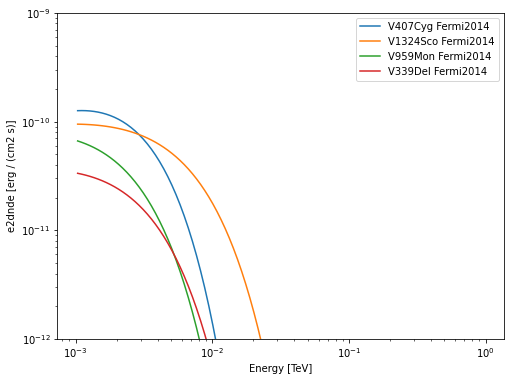

In [9]:
#Particle distribution from Fermi novae paper. Amplitude by eye 

Cyg_particle_distribution = naima.models.ExponentialCutoffPowerLaw(3e32*u.Unit('1/eV'), 
                                                                   130.0 * u.GeV, 
                                                                   1.4, 
                                                                   10*u.GeV)
Cyg_radiative_model = naima.models.PionDecay(Cyg_particle_distribution, nh=1.7e9 * u.cm ** -3)
Cyg_spec_model = NaimaSpectralModel(Cyg_radiative_model, distance=2.7 * u.kpc)


Sco_particle_distribution = naima.models.ExponentialCutoffPowerLaw(8e29*u.Unit('1/eV'), 
                                                                   130.0 * u.GeV, 
                                                                   2.6, 
                                                                   32*u.GeV)
Sco_radiative_model = naima.models.PionDecay(Sco_particle_distribution, nh=5.1e10 * u.cm ** -3)
Sco_spec_model = NaimaSpectralModel(Sco_radiative_model, distance=6.5 * u.kpc)

Mon_particle_distribution = naima.models.ExponentialCutoffPowerLaw(3e28*u.Unit('1/eV'), 
                                                                   130.0 * u.GeV, 
                                                                   2.4, 
                                                                   10*u.GeV)
Mon_radiative_model = naima.models.PionDecay(Mon_particle_distribution, nh=1.2e11 * u.cm ** -3)
Mon_spec_model = NaimaSpectralModel(Mon_radiative_model, distance=1.4 * u.kpc)


Del_particle_distribution = naima.models.ExponentialCutoffPowerLaw(1.5e28*u.Unit('1/eV'), 
                                                                   130.0 * u.GeV, 
                                                                   2.6, 
                                                                   15*u.GeV)
Del_radiative_model = naima.models.PionDecay(Del_particle_distribution, nh=5.5e11 * u.cm ** -3)
Del_spec_model = NaimaSpectralModel(Del_radiative_model, distance=4.5 * u.kpc)

opts = {
    "energy_bounds": [1 * u.GeV, 1 * u.TeV],
    "sed_type": "e2dnde",
}
plt.figure(figsize=(8,6))
# Plot the total inverse Compton emission
# spec_model.plot(label="RS Oph average", **opts)
# Cyg_spec_model.plot(label="V407Cyg fit", **opts)
# Sco_spec_model.plot(label="V1324Sco fit", **opts)
# Mon_spec_model.plot(**opts, label="V959Mon fit")
# Del_spec_model.plot(**opts, label="V339Del fit")

V407Cyg.plot(**opts, label="V407Cyg Fermi2014")
V1324Sco.plot(**opts, label="V1324Sco Fermi2014")
V959Mon.plot(**opts, label="V959Mon Fermi2014")
V339Del.plot(**opts, label="V339Del Fermi2014")

sim_model=SkyModel(spectral_model=spec_model, name="first days")
plt.ylim((1e-12,1e-9))
plt.legend()

# Simulation and spectral fitting of RS Oph

In [10]:
file="CTAN-IRFs/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-SouthAz-4LSTs09MSTs.18000s-v0.1.fits.gz"


Aeff = EffectiveAreaTable2D.read(file)
Edisp = EnergyDispersion2D.read(file,hdu='ENERGY DISPERSION')
Bkg = Background3D.read(file)


irfs_dict = {
  "aeff": Aeff,
  "bkg": Bkg,
  "edisp": Edisp
}
irfs_dict

{'aeff': <gammapy.irf.effective_area.EffectiveAreaTable2D at 0x167f48700>,
 'bkg': <gammapy.irf.background.Background3D at 0x167f990d0>,
 'edisp': <gammapy.irf.edisp.core.EnergyDispersion2D at 0x167e79bb0>}

In [11]:
#position of source
pos = SkyCoord.from_name("RS Oph")

energy_axis = MapAxis.from_energy_bounds(
    0.02, 1, nbin=5, per_decade=True, unit="TeV", name="energy"
)
e_reco=energy_axis.copy()
on_region_radius = Angle("0.2 deg")
pointing = pos
offset = 0.5 * u.deg
center = pointing.directional_offset_by(position_angle=0 * u.deg, separation=offset)

on_region = CircleSkyRegion(center=center, radius=on_region_radius)

geom = RegionGeom.create(region=on_region, axes=[e_reco])

energy_axis_true = e_true = MapAxis.from_energy_bounds(
    0.005, 50, nbin=10, per_decade=True, unit="TeV", name="energy_true"
)

In [12]:
# create the runs each 5 min long
t_int = 180*u.min
gti_t_ref = Time("2020-03-01T02:00:00.0")# yyyy-mm-dd Thh:mm:ss


sim_obs = Observation.create(irfs=irfs_dict,
                         pointing=pointing, 
                         livetime=t_int,
                         tstart=0*u.s,
                         reference_time=gti_t_ref,
                         obs_id=0)

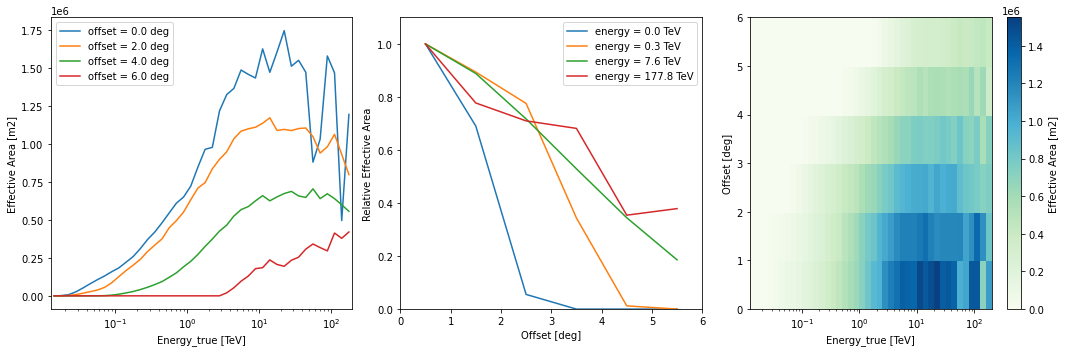

In [13]:
sim_obs.aeff.peek()

In [14]:
particle_distribution_MAGIC_RSOph = naima.models.ExponentialCutoffPowerLaw(8e31*u.Unit('1/eV'), 
                                                               130.0 * u.GeV, 
                                                               2.21, 
                                                               0.257*u.TeV)

radiative_model_MAGIC_RSOph = naima.models.PionDecay(particle_distribution_MAGIC_RSOph, nh=6.0e8 * u.cm ** -3)
spec_model_MAGIC_RSOph = NaimaSpectralModel(radiative_model_MAGIC_RSOph, distance=2.45 * u.kpc)

In [15]:
# Make the SpectrumDataset and maker
simulated_dataset_empty = SpectrumDataset.create(geom=geom,
                                                 name="sim")

maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])

contador=0
dataset_empty=simulated_dataset_empty.copy(name="obs_{}".format(contador))
short_dataset = maker.run(dataset_empty, sim_obs)

short_dataset.models = SkyModel(spectral_model=spec_model_MAGIC_RSOph)

short_dataset.fake()

short_datasets=Datasets(short_dataset)    
short_datasets.info_table()

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str7,int64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
stacked,20029,8762.310546875,11266.689,102.87582140486057,8762.310939788818,8762.310546875,nan,149271424.0,6658331648.0,10800.0,10800.0,1.854537037037037,0.8113250506365741,1.043211986400463,9,9,cash,nan


In [16]:
short_datasets_on_off=Datasets()

for obs in short_datasets:
    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
        dataset=obs, acceptance=1, acceptance_off=3)
    
    # overwrite counts and off-counts with the fake method 
    dataset_on_off.fake(npred_background=obs.npred_background())
    short_datasets_on_off.append(dataset_on_off)
    

short_datasets_on_off.models=None #I remove the model because if a model is set, the wstat computes the statistics
                              # with that model. Then, the wstat changes with respect to the Li&Ma TS value
    
    
short_datasets_on_off.info_table()

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,20002,8825.333984375,11176.666,84.6355931116082,11619.50025971606,11619.50025971606,nan,149271424.0,6658331648.0,10800.0,10800.0,1.852037037037037,0.8171605541087963,1.0348764829282406,9,9,wstat,8464.366636544763,26476,9.0,26.999998008219855,0.3333333432674408


In [17]:
#spectral component
spectral_model_simu = LogParabolaSpectralModel(
    alpha=2.8,
    beta=0.3,
    amplitude=2.5e-10 * u.Unit("cm-2 s-1 TeV-1"),
    reference=0.1 * u.TeV,
)


# we set the sky model (simulated source) used in the dataset
fit_spec_model = SkyModel(spectral_model=spectral_model_simu, name="fit source")

fit_dataset_on_off=short_datasets_on_off.copy()
best_fit_spec_model=fit_spec_model.copy(name="best fit source")# I use copy bc I don t want that the fit_spec_model's parameters 
                                         #change when fitting bc I will use the same model later

    
#define the model we want to fit into the SpectrumDatasetOnOff
fit_dataset_on_off.models = best_fit_spec_model


#fitting process
fit = Fit()
result = fit.run(fit_dataset_on_off)


#print the table with the paramters fitted
#best_fit_spec_model.spectral_model.parameters.to_table()
result.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,float64,float64,float64,bool,str1
spectral,amplitude,1.5144e-09,cm-2 s-1 TeV-1,4.355e-11,nan,nan,False,
spectral,reference,1.0000e-01,TeV,0.000e+00,nan,nan,True,
spectral,alpha,3.8476e+00,,6.210e-02,nan,nan,False,
spectral,beta,4.4285e-01,,5.070e-02,nan,nan,False,


In [18]:
fpe = FluxPointsEstimator(energy_edges=e_reco.edges, n_sigma_ul=2, selection_optional="all")

flux_points = fpe.run(fit_dataset_on_off)

In [19]:
FluxPoint_kwargs = {
    "color": 'r',
    "marker":'o', 
    "capsize": 3, 
    "capthick": 1,
}

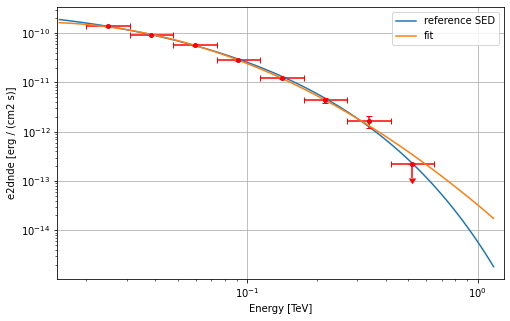

In [20]:
opts_fit = {
    "energy_bounds": [15 * u.GeV, 1.2 * u.TeV],
    "sed_type": "e2dnde",
}

fig,ax=plt.subplots(figsize=(8, 5))
ax=spec_model_MAGIC_RSOph.plot(label="reference SED", **opts_fit)
ax = flux_points.plot(sed_type="e2dnde", **FluxPoint_kwargs)

ax.set_xlim((15,1300)*u.GeV)
best_fit_spec_model.spectral_model.plot(label="fit",**opts_fit)
plt.grid("both")
plt.legend()
# plt.savefig("../SED_SimRSOph_CTAN_tobs-5h.png",dpi=250)

# Temporal variations

Using temporal profile from HESS and considering spectral variations for the first 4 days.


### Stacked MAGIC particle distribution

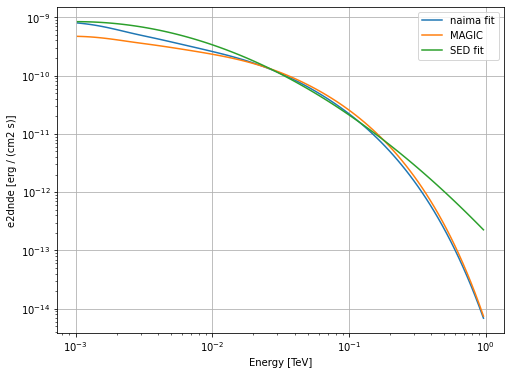

/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


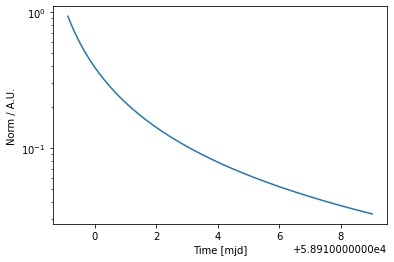

In [93]:
plt.figure(figsize=(8,6))

opts_plot = {
    "yunits": u.Unit("erg cm-2 s-1"),
    "energy_bounds": [1 * u.GeV, 1 * u.TeV],
    "sed_type": "e2dnde",
}


#amplitude by eye
particle_distribution_MAGIC_RSOph = naima.models.ExponentialCutoffPowerLaw(8e31*u.Unit('1/eV'), 
                                                               130.0 * u.GeV, 
                                                               2.21, 
                                                               0.257*u.TeV)

radiative_model_MAGIC_RSOph = naima.models.PionDecay(particle_distribution_MAGIC_RSOph, nh=6.0e8 * u.cm ** -3)
spec_model_MAGIC_RSOph = NaimaSpectralModel(radiative_model_MAGIC_RSOph, distance=2.45 * u.kpc)


SED_spec_model = LogParabolaSpectralModel(
    amplitude=5.08e-10* u.Unit("TeV-1 cm-2 s-1"),
    alpha=3.697,
    beta=0.175,
    reference=0.13*u.TeV
)

sim_model.spectral_model.plot(**opts_plot,label="naima fit")
spec_model_MAGIC_RSOph.plot(**opts_plot,label="MAGIC")
SED_spec_model.plot(**opts_plot,label="SED fit")
plt.grid("both")
plt.legend()
plt.show()

#temporal model
decay_model = PowerLawTemporalModel(
    alpha = -1.43,
    t_ref= gti_t_ref.mjd*u.d-1*u.d
)
sim_model_time=SkyModel(spectral_model=spec_model_MAGIC_RSOph, temporal_model=decay_model,
                       name="w temp model")

decay_model.plot(Time([gti_t_ref.mjd,gti_t_ref.mjd+10],format="mjd"))

plt.yscale("log")

### Daily HESS spectral model (SED)

/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in pow

(1e-13, 5e-09)

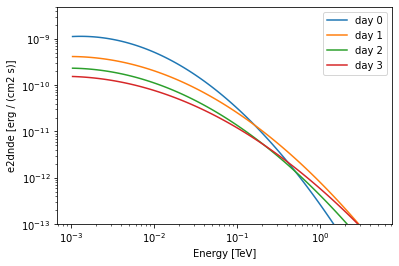

In [115]:
#SED fit from HESS

alpha_array=[1.9,2.01,2.02,2.05]
beta_array=[0.19,0.13,0.13,0.11,0.12]

opts_plot = {
    "yunits": u.Unit("erg cm-2 s-1"),
    "energy_bounds": [1 * u.GeV, 5 * u.TeV],
    "sed_type": "e2dnde",
}


list_models_HESS=[]
for day,(alpha,beta) in enumerate(zip(alpha_array,beta_array)):
    
    spec=LogParabolaSpectralModel(
        amplitude=7e-7 * u.Unit("GeV-1 cm-2 s-1"),
        alpha=alpha,
        beta=beta,
        reference=e_ref
    )
    
    model=SkyModel(spectral_model=spec, temporal_model=decay_model, name="model day {}".format(day))
    list_models_HESS.append(model)
    
    
#Plot SEDs    
for day,model in enumerate(list_models_HESS):
    temp_model=model.copy()
    
    frac_t=sim_model_time.temporal_model.evaluate(time=gti_t_ref.mjd*u.d+day*u.d,
                                          alpha=-1.43,
                                          t_ref=gti_t_ref.mjd*u.d-1*u.d,
                                          t0=1*u.d)   
    
    temp_model.spectral_model.amplitude.value=temp_model.spectral_model.amplitude.value*frac_t

    temp_model.spectral_model.plot(**opts_plot,label="day %i"%day)

plt.legend()    
plt.ylim((1e-13,5e-9))

### Daily MAGIC particle distribution

/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in pow

(1e-13, 5e-09)

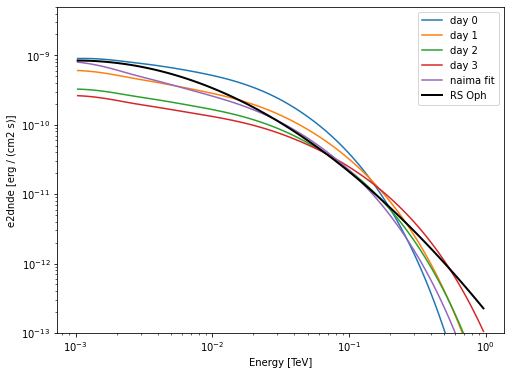

In [134]:
#particle distribution fit from MAGIC

opts_plot = {
    "yunits": u.Unit("erg cm-2 s-1"),
    "energy_bounds": [1 * u.GeV, 1 * u.TeV],
    "sed_type": "e2dnde",
}

index_array=[2.02,2.25,2.23,2.3]
ecutoff_array=[0.158,0.278,0.317,0.525]*u.TeV

list_models_MAGIC=[]
plt.figure(figsize=(8,6))
for day,(index,ecutoff) in enumerate(zip(index_array,ecutoff_array)):
    
    #amplitude fitted by eye
    particle = naima.models.ExponentialCutoffPowerLaw(2.5e32*u.Unit('1/eV'),
                                                       130.0 * u.GeV, 
                                                       index, 
                                                       ecutoff)
    radiative_model = naima.models.PionDecay(particle, nh=6.0e8 * u.cm ** -3)
    spec = NaimaSpectralModel(radiative_model, distance=2.45 * u.kpc)
    
    model=SkyModel(spectral_model=spec, temporal_model=decay_model, name="model day {}".format(day))
    list_models_MAGIC.append(model)
    
#Plots SEDs    
for day,model in enumerate(list_models_MAGIC):
    temp_model=model.copy()
    
    frac_t=sim_model_time.temporal_model.evaluate(time=gti_t_ref.mjd*u.d+day*u.d,
                                          alpha=-1.43,
                                          t_ref=gti_t_ref.mjd*u.d-1*u.d,
                                          t0=1*u.d)   
    
    temp_model.spectral_model.amplitude.value=temp_model.spectral_model.amplitude.value*frac_t

    temp_model.spectral_model.plot(**opts_plot,label="day %i"%day)
sim_model.spectral_model.plot(**opts_plot,label="naima fit")
SED_spec_model.plot(label="RS Oph", **opts, color="k", lw=2)

plt.legend()        
plt.ylim((1e-13,5e-9))

OJO: If a naima spectral model is used, the computation time increases x2

## Start simulations...

In [21]:
# create the runs each 5 min long
t_int = 180*u.min
gti_t_ref = Time("2020-03-01T02:00:00.0")# yyyy-mm-dd Thh:mm:ss

array_obs=[]

for day in range(0,50+1,1):

    sim_obs = Observation.create(irfs=irfs_dict,
                         pointing=pointing, 
                         livetime=t_int,
                         tstart=0*u.s,
                         reference_time=gti_t_ref+day*u.d,
                         obs_id=day)
    array_obs.append(sim_obs)

In [135]:
%%time
# Make the SpectrumDataset and maker
simulated_dataset_empty = SpectrumDataset.create(geom=geom,
                                                 name="sim")

maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])



shortobs_array=[]
ntimes=50

for n in range(ntimes):

    short_datasets=Datasets()
    for contador,sim_obs in enumerate(array_obs):
        dataset_empty=simulated_dataset_empty.copy(name="obs_{}".format(contador))
        short_dataset = maker.run(dataset_empty, sim_obs)

        #choose SkyModel with spectral variations
        if contador<=3:
            short_dataset.models = list_models_MAGIC[contador]
        else:
            short_dataset.models = list_models_MAGIC[-1]
        #MAGIC SkyModel (no spectral variations)
        #short_dataset.models=sim_model_time
            
        short_dataset.fake()

        short_datasets.append(short_dataset) 



    short_datasets_on_off=Datasets()

    for obs in short_datasets:
        dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
            dataset=obs, acceptance=1, acceptance_off=3)

        #print(dataset_on_off)
        # overwrite counts and off-counts with the fake method 
        dataset_on_off.fake(npred_background=obs.npred_background())
        short_datasets_on_off.append(dataset_on_off)

    short_datasets_on_off.models=None #I remove the model because if a model is set, the wstat computes the statistics
                                  # with that model. Then, the wstat changes with respect to the Li&Ma TS value since
                                  # it will be the fit statistics

    shortobs_array.append(short_datasets_on_off)
    

CPU times: user 12min 2s, sys: 2.28 s, total: 12min 4s
Wall time: 12min 4s


In [136]:
shortobs_array[0].info_table()

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str8,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,28085,8816.6669921875,19268.33203125,132.41600247787255,13633.750304738056,13633.750304738056,nan,149271424.0,6658331648.0,10800.0,10800.0,2.600462962962963,0.8163580548321759,1.7841048177083334,9,9,wstat,20118.611720386594,26450,9.0,26.999999003130945,0.3333333432674408
KCIsyGCt,22310,8776.666666666666,13533.333333333334,99.54425624239889,12160.0,12160.0,nan,149271427.21270555,6658331670.952252,10800.0,10800.0,2.0657407407407407,0.8126543209876542,1.2530864197530864,9,9,wstat,11306.894495402013,26330,9.0,27.000000000000004,0.3333333333333333
ksv9X3ws,17592,8798.666666666666,8793.333333333334,68.96676228723008,10997.0,10997.0,nan,149271427.21270555,6658331670.952252,10800.0,10800.0,1.6288888888888888,0.8146913580246913,0.8141975308641975,9,9,wstat,5638.429869818634,26396,9.0,27.000000000000004,0.3333333333333333
xLIVZdfT,17247,8694.333333333334,8552.666666666666,67.62021765037626,10832.5,10832.5,nan,149271427.21270555,6658331670.952252,10800.0,10800.0,1.5969444444444445,0.8050308641975309,0.7919135802469135,9,9,wstat,5394.4499878687375,26083,9.0,26.999999999999996,0.3333333333333333
Rt9SocIN,15011,8672.666666666666,6338.333333333334,51.96394507728615,10257.25,10257.25,nan,149271427.21270555,6658331670.952252,10800.0,10800.0,1.3899074074074074,0.8030246913580247,0.5868827160493828,9,9,wstat,3115.9769050231707,26018,9.0,27.000000000000004,0.3333333333333333
7oDxone8,13756,8783.666666666666,4972.333333333334,41.52146861788996,10026.75,10026.75,nan,149271427.21270555,6658331670.952252,10800.0,10800.0,1.2737037037037038,0.8133024691358024,0.4604012345679013,9,9,wstat,2100.1650083525246,26351,9.0,27.000000000000004,0.3333333333333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FWK0JZO8,9130,8735.666666666666,394.33333333333394,3.620086641992514,8834.25,8834.25,nan,149271427.21270555,6658331670.952252,10800.0,10800.0,0.8453703703703703,0.8088580246913579,0.0365123456790124,9,9,wstat,23.321796217279825,26207,9.0,27.000000000000004,0.3333333333333333


In [137]:
def plot_sqrt_ts(shortobs_array,output_name,saveimage=False,run_start=None,run_end=None,cumulative_bool=False):
    """
    Plot the distribution of Li&Ma significance for a certain number of runs. Cumulative distribution is
    also available.
    """
    
    array_sqrt_ts=np.ones((len(shortobs_array),
                           np.shape(Datasets(shortobs_array[0][run_start:run_end]).info_table(cumulative=cumulative_bool)["sqrt_ts"].value)[0]))

    for i,shortobs in enumerate(shortobs_array):
        array_sqrt_ts[i,:]=Datasets(shortobs[run_start:run_end]).info_table(cumulative=cumulative_bool)["sqrt_ts"].value
        
    mean=np.mean(array_sqrt_ts,axis=0)
    std=np.std(array_sqrt_ts,axis=0)

    initial_run_num=len(shortobs_array[0][:])-len(shortobs_array[0][run_start:])
    end_run_num=initial_run_num+len(shortobs_array[0][run_start:run_end])
    
    fig,ax=plt.subplots(figsize=(8,6))
    ax.errorbar(x=np.arange(initial_run_num,end_run_num),
                y=mean,
                yerr=std,
                ls="",
                capsize=3, 
                marker="o")
    ax.set_xlabel("Days since peak at VHE [d]")
    ax.set_ylabel("Li&Ma Sig. (eq. 17)")
    if cumulative_bool:
        ax.set_ylabel("Cumulative Li&Ma Sig. (eq. 17)")
    ax.grid("both")
    
    if saveimage:
        fig.savefig("{}_Li&MaSig_nsim-{}_tobs-{:1.0f}{}_cumulative-{}_d{}-d{}.png".format(output_name,
                                                                                       len(shortobs_array),
                                                                                       shortobs_array[0][0].gti.time_delta.to("min")[0].value,
                                                                                       "min",
                                                                                       cumulative_bool,
                                                                                       initial_run_num,
                                                                                       end_run_num),dpi=250)
    

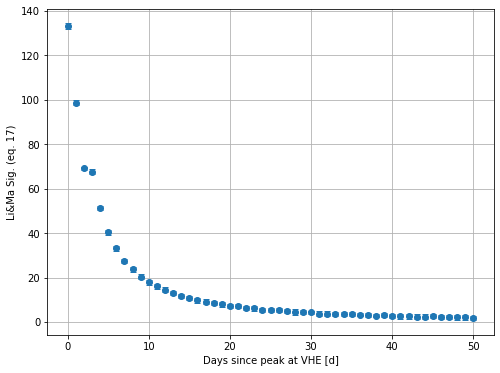

In [138]:
plot_sqrt_ts(shortobs_array,output_name="RSOph_CTAN_zd40",saveimage=False)

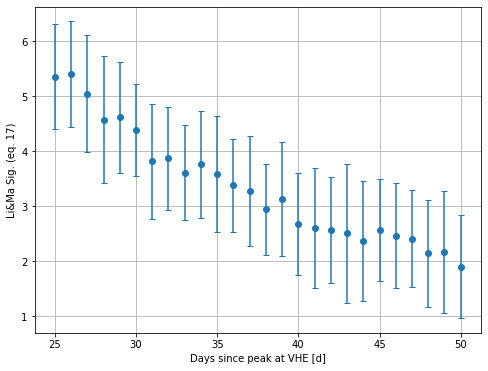

In [142]:
plot_sqrt_ts(shortobs_array,run_start=25,run_end=None,output_name="RSOph_CTAN_zd40",saveimage=False)

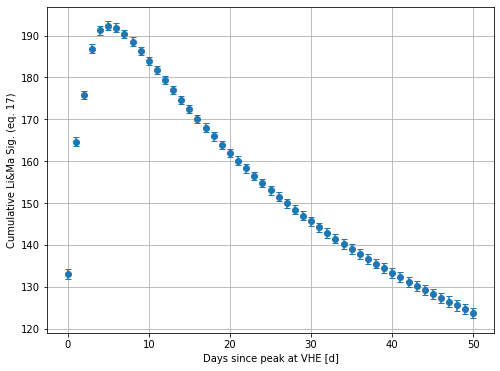

In [140]:
plot_sqrt_ts(shortobs_array,cumulative_bool=True,output_name="RSOph_CTAN_zd40",saveimage=False)

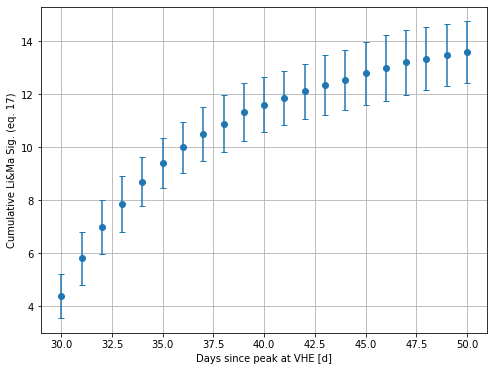

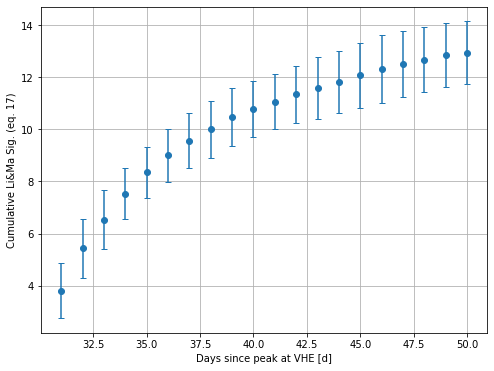

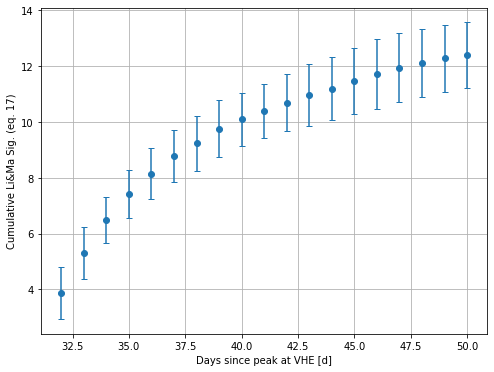

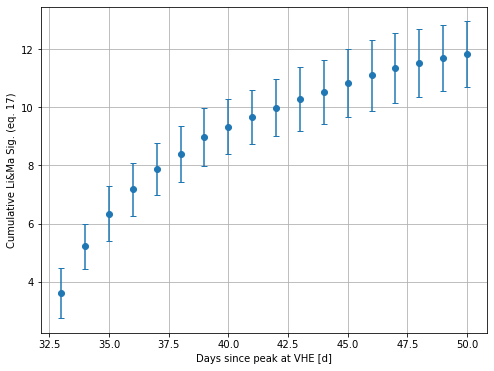

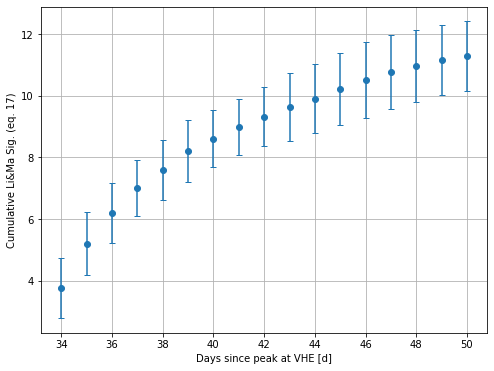

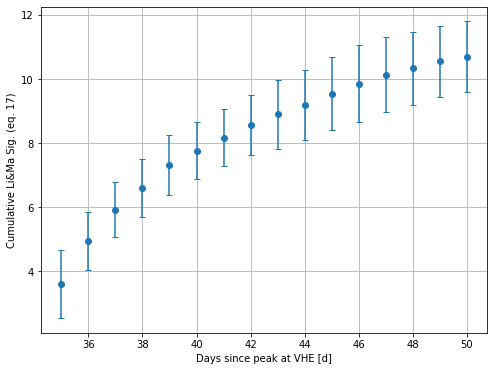

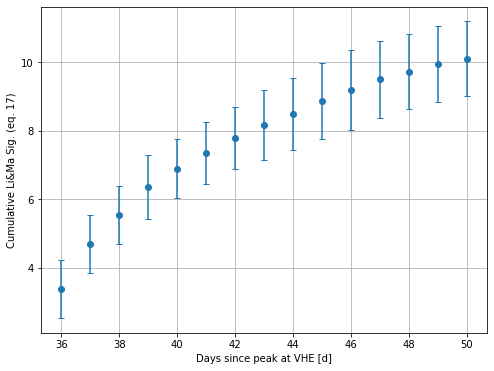

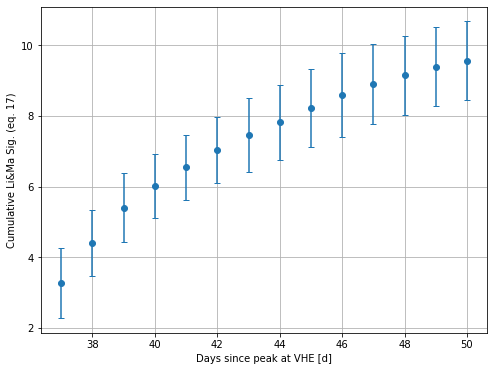

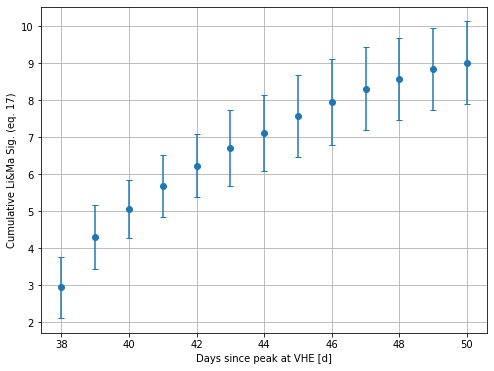

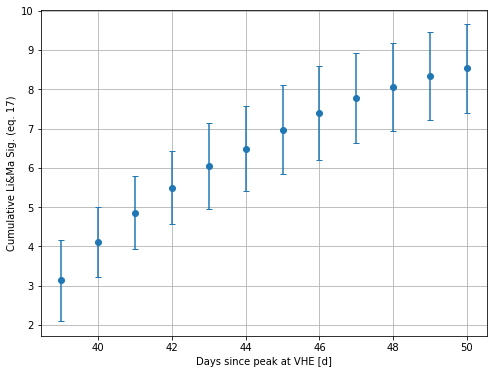

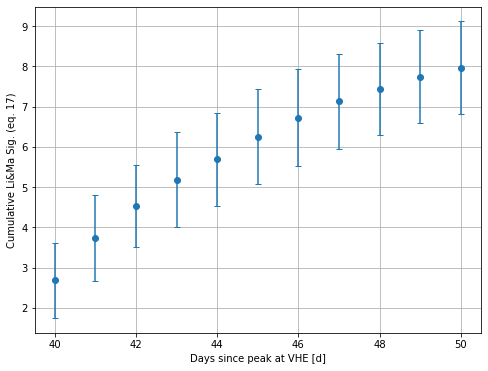

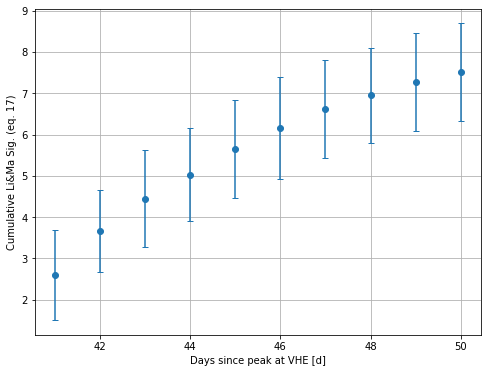

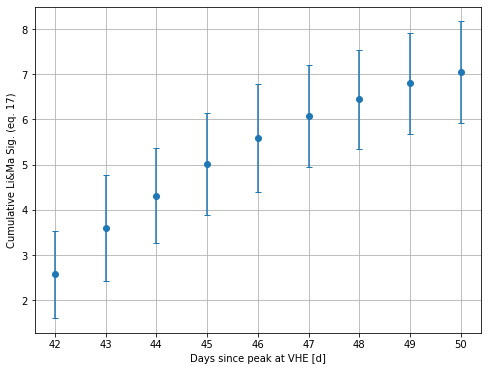

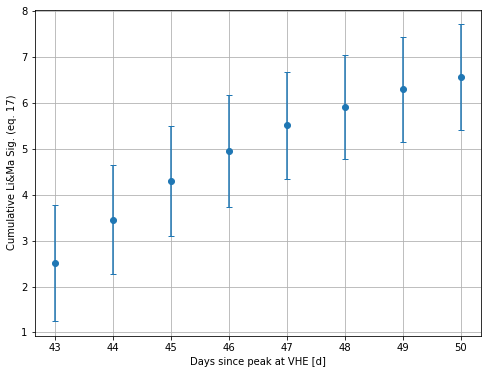

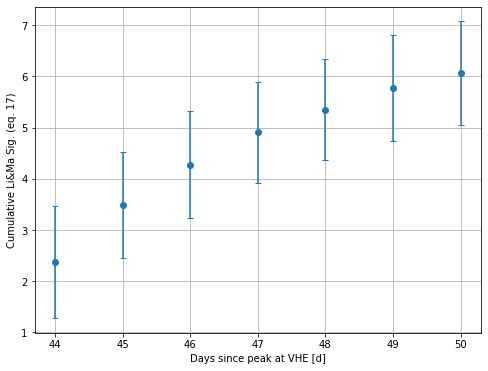

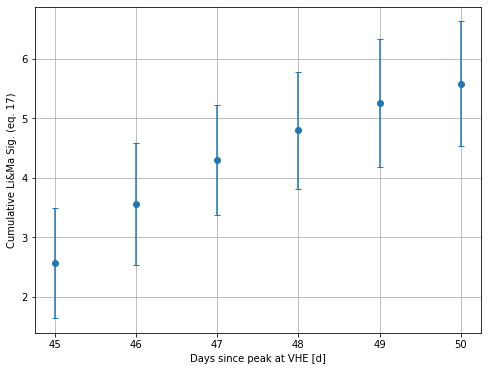

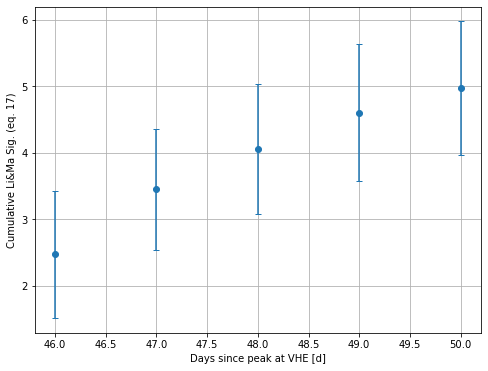

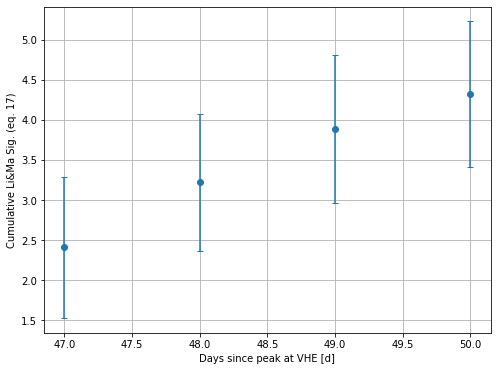

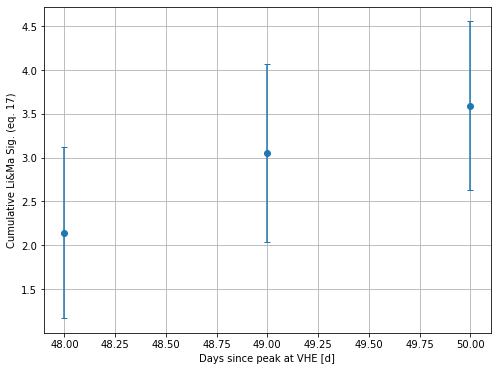

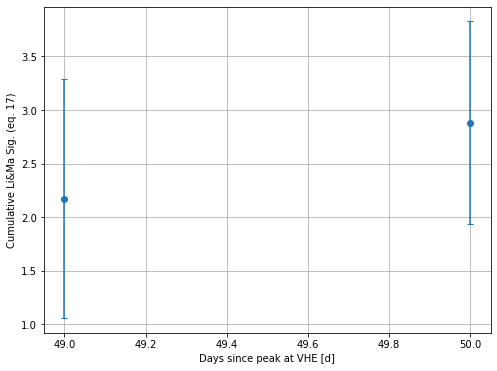

In [145]:
#Plot the cumulative significance to find the last day from witch the cumulative significance give
#5 sigma detection
for i in range(30,50,1):
    plot_sqrt_ts(shortobs_array,run_start=i,run_end=None,
                 cumulative_bool=True,output_name="RSOph_CTAN_zd40",saveimage=False)
    plt.show()

# Fermi novae

Obtain the distribtion of Li&Ma significance eq.17 using Fermi novae SEDs. Computation time: 26min 37s!!

In [ ]:
#bkg rate for different IRFs
#1800 (30min) -> 2207.91
#18000 (5h) -> 724.81
#180000 (50h) -> 272.18

In [ ]:
%%time

file="CTAN-IRFs/CTA-Performance-prod5-v0.1-North-20deg.FITS/Prod5-North-20deg-SouthAz-4LSTs09MSTs.1800s-v0.1.fits.gz"


Aeff = EffectiveAreaTable2D.read(file)
Edisp = EnergyDispersion2D.read(file,hdu='ENERGY DISPERSION')
Bkg = Background3D.read(file)


irfs_dict = {
  "aeff": Aeff,
  "bkg": Bkg,
  "edisp": Edisp
}

energy_axis = MapAxis.from_energy_bounds(
    0.02, 1, nbin=5, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = e_true = MapAxis.from_energy_bounds(
    0.01, 50, nbin=10, per_decade=True, unit="TeV", name="energy_true"
)

e_reco=energy_axis.copy()
on_region_radius = Angle("0.2 deg")
pointing = SkyCoord.from_name("V959Mon")
offset = 0.5 * u.deg
center = pointing.directional_offset_by(position_angle=0 * u.deg, separation=offset)
on_region = CircleSkyRegion(center=center, radius=on_region_radius)
geom = RegionGeom.create(region=on_region, axes=[e_reco])


t_int = 15*u.min
gti_t_ref = Time("2020-03-01T02:00:00.0")# yyyy-mm-dd Thh:mm:ss

sim_obs_array=[]
for i in range(int(((2*u.h).to("min")/(15*u.min)).value)):
    sim_obs = Observation.create(irfs=irfs_dict,
                         pointing=pointing, 
                         livetime=t_int,
                         tstart=(i*t_int).to("s"),
                         reference_time=gti_t_ref,
                         obs_id=i)
    sim_obs_array.append(sim_obs)


# Make the SpectrumDataset and maker
simulated_dataset_empty = SpectrumDataset.create(geom=geom,
                                                 name="sim")

maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])    
    
shortobs_LiMa_sig_array=[]
stackedobs_LiMa_sig_array=[]
ntimes=1000

for n in range(ntimes):

    short_datasets=Datasets()
    for contador,sim_obs in enumerate(sim_obs_array):
        dataset_empty=simulated_dataset_empty.copy(name="obs_{}".format(contador))
        short_dataset = maker.run(dataset_empty, sim_obs)

        short_dataset.models = SkyModel(spectral_model=V959Mon)

        short_dataset.fake()
        short_datasets.append(short_dataset) 

    short_datasets_on_off=Datasets()

    for obs in short_datasets:
        dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
            dataset=obs, acceptance=1, acceptance_off=3)

        #print(dataset_on_off)
        # overwrite counts and off-counts with the fake method 
        dataset_on_off.fake(npred_background=obs.npred_background())
        short_datasets_on_off.append(dataset_on_off)

    short_datasets_on_off.models=None #I remove the model because if a model is set, the wstat computes the statistics
                                  # with that model. Then, the wstat changes with respect to the Li&Ma TS value
    shortobs_LiMa_sig_array=np.concatenate((shortobs_LiMa_sig_array, 
                                            short_datasets_on_off.info_table()["sqrt_ts"].value), axis=None)

    stacked_datasets_on_off=Datasets(short_datasets_on_off.stack_reduce())
    stackedobs_LiMa_sig_array.append(stacked_datasets_on_off.info_table()["sqrt_ts"].value[0])

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(12,6))

axs[0].hist(shortobs_LiMa_sig_array)
axs[0].set_title("15 min run")
axs[0].set_ylabel("# of runs")
axs[0].set_xlabel("sqrt Li&Ma sig. (eq. 17)")
ymax,ymin=axs[0].set_ylim()
axs[0].vlines(np.median(shortobs_LiMa_sig_array),ymin,ymax, zorder=100, color="k", ls="--", label="median")


axs[1].hist(stackedobs_LiMa_sig_array)
axs[1].set_title("2 hours (stack 8 runs)")
axs[1].set_ylabel("# of runs")
axs[1].set_xlabel("sqrt Li&Ma sig. (eq. 17)")
ymax,ymin=axs[1].set_ylim()
axs[1].vlines(np.median(stackedobs_LiMa_sig_array),ymin,ymax, zorder=100, color="k", ls="--", label="median")

plt.tight_layout()
# plt.savefig("../hist_Li&MaSig_nsim-{}_tobs-{}_{}.png".format(ntimes,"15min","V959Mon"),dpi=250)

# Differential sensitivity

Plot the differential sensitivity as a function of energy or time in order to study if a given SED is. above (would be detected at 5 sigma in each energy bin) or below (not detected at 5 sigma) the significance of CTA-N.

Differential sensitivity plot: the SED for a 50 hours observation of a point-like object for a 5 sigma detection (+ other constraints at different energy range) using 5 energy bins per decade.


In [117]:
def total_sig(dataset,gamma_min=10,n_sigma=5,bkg_syst_fraction=0.05):
    """
    Compute the total significance in the energy range of the differential sensitivity
    """
    n_off = dataset.counts_off.data

    stat = WStatCountsStatistic(
        n_on=dataset.alpha.data * n_off, n_off=n_off, alpha=dataset.alpha.data
    )
    excess_counts = stat.n_sig_matching_significance(n_sigma)
    is_gamma_limited = excess_counts < gamma_min
    excess_counts[is_gamma_limited] = gamma_min
    bkg_syst_limited = (
        excess_counts < bkg_syst_fraction * dataset.background.data
    )
    excess_counts[bkg_syst_limited] = (
        bkg_syst_fraction * dataset.background.data[bkg_syst_limited]
    )

#     print("noff",n_off.reshape(-1))
#     print(is_gamma_limited.reshape(-1))
#     print(bkg_syst_limited.reshape(-1))
#     print( )
    sqrt_ts=WStatCountsStatistic(
        n_on=np.sum(excess_counts.reshape(-1)+dataset.alpha.data.reshape(-1) * n_off.reshape(-1)), 
        n_off=np.sum(n_off.reshape(-1)), 
        alpha=np.mean(dataset.alpha.data.reshape(-1))
    ).sqrt_ts
    return sqrt_ts

In [118]:
def integral_sensitivity(table):
    """
    Compute the sensitivity over the whole energy range. Integral of the differential sensitivity.
    """
    from scipy.integrate import trapezoid
    integral=trapezoid(table["e2dnde"],table["energy"])
    return integral

## Differential sensitivity as a function of energy
Plot the differential sensitivity for different observation times! -> Differential time differential sensitivity

In [119]:
Aeff = EffectiveAreaTable2D.read(file)
Edisp = EnergyDispersion2D.read(file,hdu='ENERGY DISPERSION')
Bkg = Background3D.read(file)




irfs_dict = {
  "aeff": Aeff,
  "bkg": Bkg,
  "edisp": Edisp
}
irfs_dict

{'aeff': <gammapy.irf.effective_area.EffectiveAreaTable2D at 0x18f35da00>,
 'bkg': <gammapy.irf.background.Background3D at 0x18f227d30>,
 'edisp': <gammapy.irf.edisp.core.EnergyDispersion2D at 0x18f215fa0>}

In [120]:
pos = SkyCoord.from_name("RS Oph")
e_reco_sensitivity = MapAxis.from_energy_bounds(
    0.02, 80, nbin=5, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true_sensitivity = e_true = MapAxis.from_energy_bounds(
    0.005, 200, nbin=10, per_decade=True, unit="TeV", name="energy_true"
)
on_region_radius = Angle("0.2 deg")
pointing = pos
offset = 0.5 * u.deg
center = pointing.directional_offset_by(position_angle=0 * u.deg, separation=offset)
on_region = CircleSkyRegion(center=center, radius=on_region_radius)
sensitivity_geom = RegionGeom.create(region=on_region, axes=[e_reco_sensitivity])

gti_t_ref = Time("2020-03-01T02:00:00.0")# yyyy-mm-dd Thh:mm:ss

#observation time of each differential sensitivity
t_interval = np.linspace(1,60*2,60*2)*u.min
# t_interval=[180]*u.min

table_sensitivity=[]
for t_int in t_interval:
    sensitivity_obs = Observation.create(irfs=irfs_dict,
                             pointing=pointing, 
                             livetime=t_int,
                             tstart=0*u.s,
                             reference_time=gti_t_ref,
                             obs_id=0)


    spectrum_maker = SpectrumDatasetMaker(
        selection=["exposure", "edisp", "background"]
    )

    #global cut in theta. See tutorial for RAD_MAX implementation
    sensitivity_dataset_empty = SpectrumDataset.create(geom=sensitivity_geom,
                                                     name="sensitivity")

    sensitivity_dataset = spectrum_maker.run(sensitivity_dataset_empty, sensitivity_obs)


    sensitivity_dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
        dataset=sensitivity_dataset, acceptance=1, acceptance_off=3
    )

    #use an spectral index similar to RS Oph. Amplitude is irrelevant
    diff_sensitivity=SensitivityEstimator(spectrum=PowerLawSpectralModel(index=4,amplitude="1e-10 cm-2 s-1 TeV-1"))#spectrum=sim_model.spectral_model)
    table=diff_sensitivity.run(sensitivity_dataset_on_off)
    
    #save the total significance and the sensitivity as a meta dta
    sqrt_ts=total_sig(sensitivity_dataset_on_off)
    I=integral_sensitivity(table)
    table.meta={"total_sig":sqrt_ts,"integral_sensitivity":I}       
    
    table_sensitivity.append(table)   

In [121]:
#np.ndarray with the sensitivity: axis 0: # of sensitivity, axis 1: # energy bins, axis 2: [energy,e2dnde]
sensitivity_plot=np.ones((len(t_interval),len(table_sensitivity[0]),2))

for y,table in enumerate(table_sensitivity):
    for i,value in enumerate(table):
        sensitivity_plot[y,i,0]=value["energy"]
        sensitivity_plot[y,i,1]=value["e2dnde"]

{'total_sig': 19.35060733521899, 'integral_sensitivity': 9.940106000737126e-08}


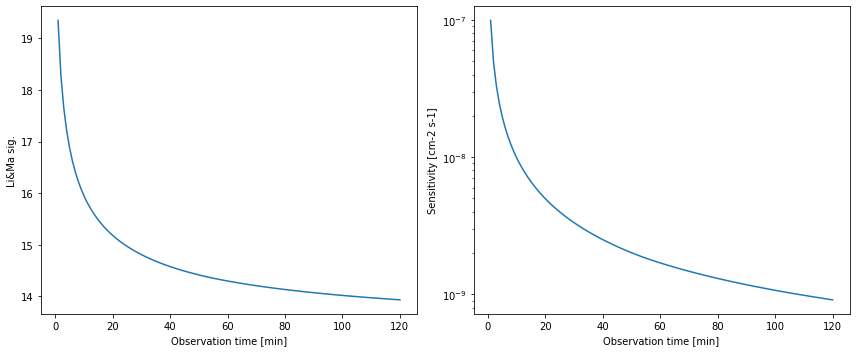

In [122]:
#checks...

print(table_sensitivity[0].meta)

array_total_sqrt_ts=[]
meta_data_table=np.zeros((2,len(table_sensitivity)))
for i,table in enumerate(table_sensitivity):
    meta_data_table[0,i]=table.meta.get("total_sig")
    meta_data_table[1,i]=table.meta.get("integral_sensitivity")
    
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t_interval.to_value("min"), meta_data_table[0,:])    
plt.xlabel("Observation time [min]")
plt.ylabel("Li&Ma sig.")
plt.subplot(1,2,2)
plt.plot(t_interval.to_value("min"), meta_data_table[1,:])    
plt.xlabel("Observation time [min]")
plt.ylabel("Sensitivity [cm-2 s-1]")
plt.yscale("log")
plt.tight_layout()

#the significance decreases over time because of the excess counts restriction at high energies...

In [123]:
def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

Text(0.5, 0, 'Energy (TeV)')

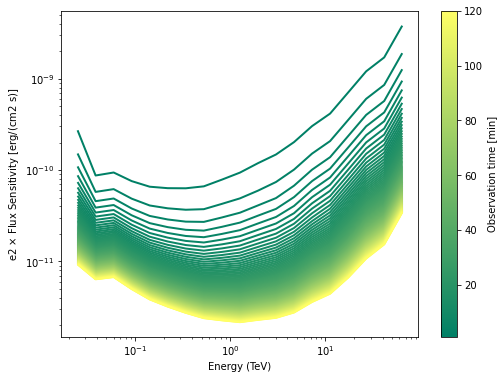

In [124]:
fig, ax = plt.subplots(figsize=(8,6))

lc = multiline(sensitivity_plot[:,:,0], sensitivity_plot[:,:,1], t_interval.to_value("min"), cmap='summer', lw=2)
plt.yscale("log")
plt.xscale("log")

axcb = fig.colorbar(lc)
axcb.set_label('Observation time [min]')
plt.ylabel(r"e2 $\times$ Flux Sensitivity [erg/(cm2 s)]")
plt.xlabel(f"Energy ({table_sensitivity[0]['energy'].unit})")


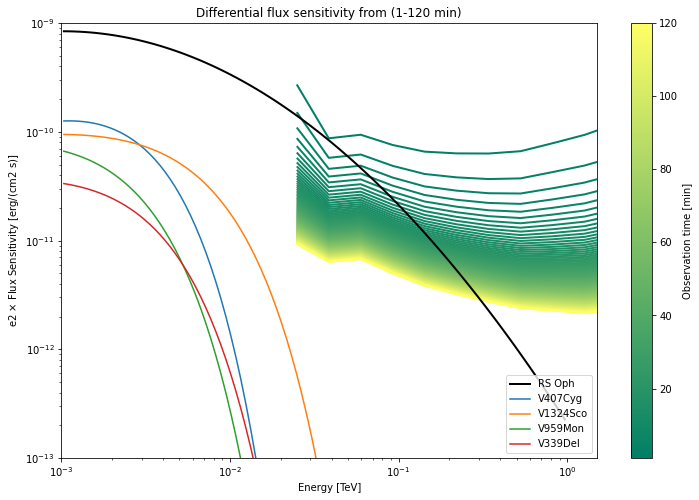

In [125]:
fig,ax=plt.subplots(figsize=(12,8))
lc = multiline(sensitivity_plot[:,:,0], sensitivity_plot[:,:,1], t_interval.to_value("min"), cmap='summer', lw=2)

axcb = fig.colorbar(lc)
axcb.set_label('Observation time [min]')
# spec_model.plot(label="RS Oph", **opts, color="k", lw=2)
SED_spec_model.plot(label="RS Oph", **opts, color="k", lw=2)

V407Cyg.plot(**opts, label="V407Cyg")
V1324Sco.plot(**opts, label="V1324Sco")
V959Mon.plot(**opts, label="V959Mon")
V339Del.plot(**opts, label="V339Del")

plt.title("Differential flux sensitivity from (1-120 min)")
plt.ylim((1e-13,1e-9))
plt.xlim((1e-3,1.5))
plt.ylabel(r"e2 $\times$ Flux Sensitivity [erg/(cm2 s)]")
plt.legend(loc="lower right")

# late_spec_model.plot(**opts)

### Differential sensitivity (fixed energy bin) as a function of time

Plot the sensitivity for a certain energy bin as a function of time. Assume the SED of the source constant over time. 

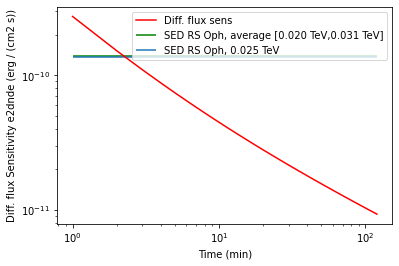

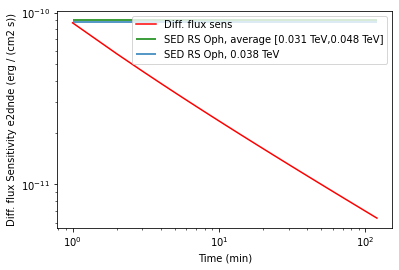

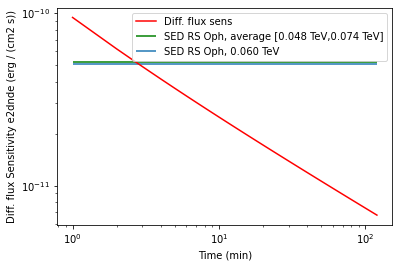

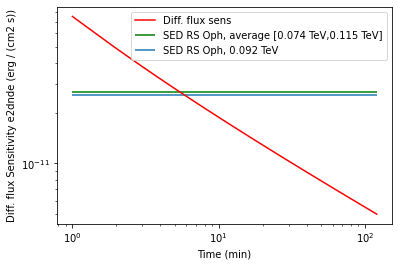

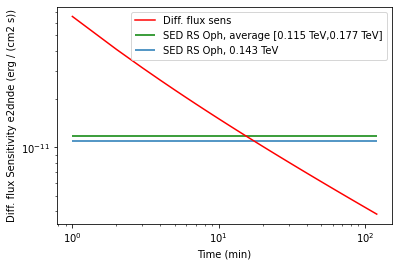

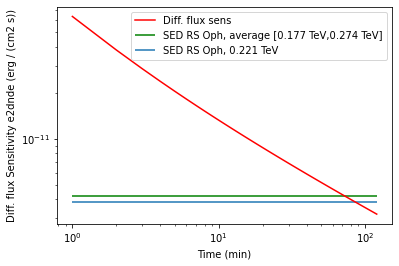

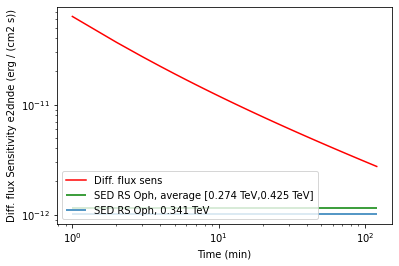

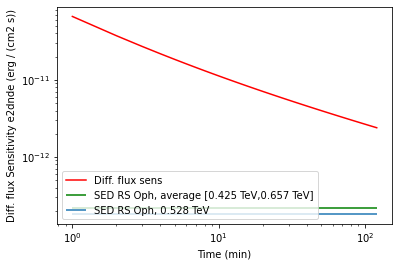

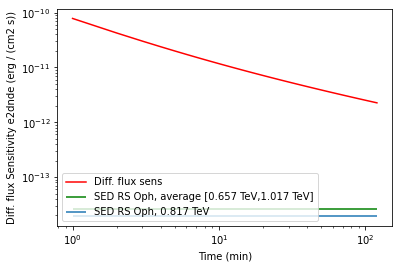

In [126]:
for energy_bin in range(9):
    average_diff_sed=sim_model.spectral_model.integral(energy_min=e_reco_sensitivity.edges[energy_bin],
                                      energy_max=e_reco_sensitivity.edges[energy_bin+1])/\
                                      (e_reco_sensitivity.edges[energy_bin+1]-e_reco_sensitivity.edges[energy_bin])
    #average SED between energy bin
    average_diff_sed1=(average_diff_sed*e_reco_sensitivity.center[energy_bin]**2).to(table_sensitivity[0]["e2dnde"].unit)
    #SED at a fixed energy
    average_diff_sed2=(sim_model.spectral_model.evaluate(e_reco_sensitivity.center[energy_bin])*e_reco_sensitivity.center[energy_bin]**2).to(table_sensitivity[0]["e2dnde"].unit)


    plt.hlines(average_diff_sed1.value,t_interval[0].value,t_interval[-1].value,color="g", label="SED RS Oph, average [{:1.3f},{:1.3f}]".format(e_reco_sensitivity.edges[energy_bin],
                                                                                                                                                e_reco_sensitivity.edges[energy_bin+1]))
    plt.hlines(average_diff_sed2.value,t_interval[0].value,t_interval[-1].value, label="SED RS Oph, {:1.3f}".format(e_reco_sensitivity.center[energy_bin]))

    diff_sens=np.ones((2,len(t_interval)))
    for i,(time,t) in enumerate(zip(t_interval,table_sensitivity)):
        diff_sens[0,i]=time.value
        diff_sens[1,i]=t["e2dnde"][energy_bin]

    plt.loglog(diff_sens[0],diff_sens[1],"r",label="Diff. flux sens")
    plt.xlabel(f"Time (min)")
    plt.ylabel(f"Diff. flux Sensitivity e2dnde ({table_sensitivity[0]['e2dnde'].unit})")
    plt.legend()
    plt.show()


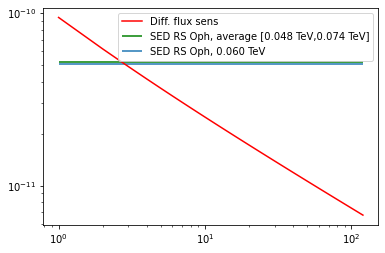

In [127]:
energy_bin=2
average_diff_sed=sim_model.spectral_model.integral(energy_min=e_reco_sensitivity.edges[energy_bin],
                                  energy_max=e_reco_sensitivity.edges[energy_bin+1])/\
                                  (e_reco_sensitivity.edges[energy_bin+1]-e_reco_sensitivity.edges[energy_bin])
average_diff_sed1=(average_diff_sed*e_reco_sensitivity.center[energy_bin]**2).to(table_sensitivity[0]["e2dnde"].unit)
average_diff_sed2=(sim_model.spectral_model.evaluate(e_reco_sensitivity.center[energy_bin])*e_reco_sensitivity.center[energy_bin]**2).to(table_sensitivity[0]["e2dnde"].unit)


plt.hlines(average_diff_sed1.value,t_interval[0].value,t_interval[-1].value,color="g", label="SED RS Oph, average [{:1.3f},{:1.3f}]".format(e_reco_sensitivity.edges[energy_bin],
                                                                                                                                 e_reco_sensitivity.edges[energy_bin+1]))
plt.hlines(average_diff_sed2.value,t_interval[0].value,t_interval[-1].value, label="SED RS Oph, {:1.3f}".format(e_reco_sensitivity.center[energy_bin]))

diff_sens=np.ones((2,len(t_interval)))
for i,(time,t) in enumerate(zip(t_interval,table_sensitivity)):
    diff_sens[0,i]=time.value
    diff_sens[1,i]=t["e2dnde"][energy_bin]

plt.loglog(diff_sens[0],diff_sens[1],"r",label="Diff. flux sens")
plt.legend()
plt.show()